<a href="https://colab.research.google.com/github/ASi-F/NLPlay-with-Transformers/blob/main/DistilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
import torch
import numpy as np
import pandas as pd
import transformers

In [3]:
df = pd.read_excel('/content/IMDB_reviews.xlsx')

In [4]:
df

,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,positive
1,Homelessness (or Houselessness as George Carli...,positive
2,Brilliant over-acting by Lesley Ann Warren. Be...,positive
3,This is easily the most underrated film inn th...,positive
4,This is not the typical Mel Brooks film. It wa...,positive
...,...,...
24995,"Towards the end of the movie, I felt it was to...",negative
24996,This is the kind of movie that my enemies cont...,negative
24997,I saw 'Descent' last night at the Stockholm Fi...,negative
24998,Some films that you pick up for a pound turn o...,negative


In [5]:
from transformers import DistilBertTokenizerFast
from torch.utils.data import Dataset, random_split, DataLoader

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {device}")

Training on cuda


In [7]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [8]:
class imdb_dataset(Dataset):
  def __init__(self,dataframe):
    self.data = dataframe['review']
    self.labels = dataframe['sentiment']
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, indx):
    review = str(self.data[indx])[:512]
    label = int(self.labels[indx] == 'positive')
    return review, label

In [9]:
dataset = imdb_dataset(df)

In [10]:
train_size = (len(dataset)*80)//100
val_size   = (len(dataset)*20)//100

train_dataset, val_dataset= random_split(dataset = dataset,
                                         lengths= [train_size, val_size],
                                         generator=torch.Generator().manual_seed(42))

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=25, shuffle= True, drop_last = False)
val_dataloader =   DataLoader(val_dataset, batch_size = 25, shuffle = True, drop_last = False)

In [12]:
from transformers import DistilBertModel
from torch import nn

In [13]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
print(model(**tokenizer(["la la la ","di", "dude"], return_tensors='pt', padding = True))[0][:,0].shape)

torch.Size([3, 768])


In [15]:
class transformer_model(nn.Module):
  def __init__(self,output_size):
    super(transformer_model, self).__init__()
    self.transformer = DistilBertModel.from_pretrained('distilbert-base-uncased')

    self.lin_layer = nn.Sequential(
        nn.Dropout(),
        nn.Linear(768, output_size)
    )
  
  def forward(self, x):
    out = self.transformer(**x)[0][:,0]
    out = self.lin_layer(out)
    return out

In [16]:
output_size = 2
model = transformer_model(output_size)
model = model.float()
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [18]:
def accuracy(pred, y):
  acc = 0
  for i in range(len(y)):
    if torch.argmax(pred[i]) == y[i]:
      acc +=1
  return acc*100/len(y)

In [19]:
from tqdm.auto import tqdm

def train(model, tokenizer, num_epochs, loss_function, optimizer):
  model.train()
  log_train_loss = []
  log_val_loss = []
  log_val_acc = []
  val_loss = 0
  val_accuracy = 0

  for reviews, labels in val_dataloader:
      tokens = tokenizer(list(reviews), return_tensors='pt', padding = True)
      for tensor in tokens.keys():
        tokens[tensor] = tokens[tensor].to(device)
      labels = labels.to(device)
      pred = model(tokens)
      val_loss += loss_function(pred, labels).item()
      val_accuracy += accuracy(pred,labels)
  val_loss /= len(val_dataloader)
  val_accuracy /= len(val_dataloader)
  print(f'Initial Val Loss:{val_loss} Val Accuracy:{val_accuracy}')

  for i in range(num_epochs):
    train_loss = []
    for reviews, labels in train_dataloader:
      tokens = tokenizer(list(reviews), return_tensors='pt', padding = True)
      for tensor in tokens.keys():
        tokens[tensor] = tokens[tensor].to(device)
      labels = labels.to(device)
      pred = model(tokens)
      loss = loss_function(pred, labels)
      train_loss.append(loss.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      progress_bar.update(1)
    train_loss = sum(train_loss[::-1][:50])/50
    log_train_loss.append(train_loss)

    val_loss = 0
    val_accuracy = 0
    for reviews, labels in val_dataloader:
      tokens = tokenizer(list(reviews), return_tensors='pt', padding = True)
      for tensor in tokens.keys():
        tokens[tensor] = tokens[tensor].to(device)
      labels = labels.to(device)
      pred = model(tokens)
      val_loss += loss_function(pred, labels).item()
      val_accuracy += accuracy(pred,labels)
      progress_bar.update(1)
    val_loss /= len(val_dataloader)
    val_accuracy /= len(val_dataloader)
    log_val_loss.append(val_loss)
    log_val_acc.append(val_accuracy)

    print(f"Epoch: [{i+1}/{num_epochs}]")
    print(f"train loss: {train_loss:>7f} -- val loss: {val_loss:>7f} -- val accc {val_accuracy:>4f}")  
  return log_train_loss, log_val_loss, log_val_acc

In [20]:
num_epochs = 2
train_losses, val_losses, val_accs = train(model, tokenizer, num_epochs, loss_function, optimizer)

  0%|          | 0/10000 [00:00<?, ?it/s]

Initial Val Loss:0.7095384418964386 Val Accuracy:50.64
Epoch: [1/10]
train loss: 0.375256 -- val loss: 0.333366 -- val accc 85.540000
Epoch: [2/10]
train loss: 0.216996 -- val loss: 0.384999 -- val accc 85.020000
Epoch: [3/10]
train loss: 0.126197 -- val loss: 0.405128 -- val accc 84.860000
Epoch: [4/10]
train loss: 0.072912 -- val loss: 0.546215 -- val accc 84.440000
Epoch: [5/10]
train loss: 0.088065 -- val loss: 0.546185 -- val accc 83.880000
Epoch: [6/10]
train loss: 0.049587 -- val loss: 0.665392 -- val accc 82.380000
Epoch: [7/10]
train loss: 0.023984 -- val loss: 0.795394 -- val accc 83.280000
Epoch: [8/10]
train loss: 0.025895 -- val loss: 0.838160 -- val accc 83.920000
Epoch: [9/10]
train loss: 0.042091 -- val loss: 0.857850 -- val accc 83.100000
Epoch: [10/10]
train loss: 0.041173 -- val loss: 0.660052 -- val accc 82.700000


In [25]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,10
plt.style.use('ggplot')

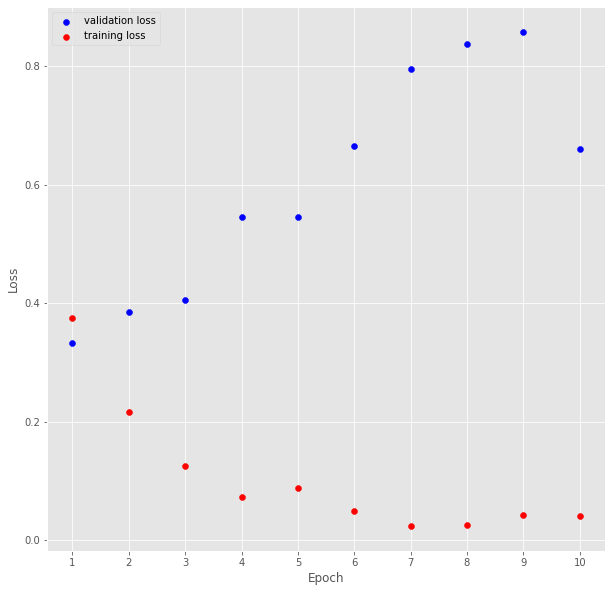

In [31]:
plt.scatter(range(1,num_epochs+1),val_losses, color = 'b', label = 'validation loss')
plt.scatter(range(1,num_epochs+1),train_losses, color = 'r', label = 'training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(list(range(1,num_epochs+1)))
plt.legend()
pass

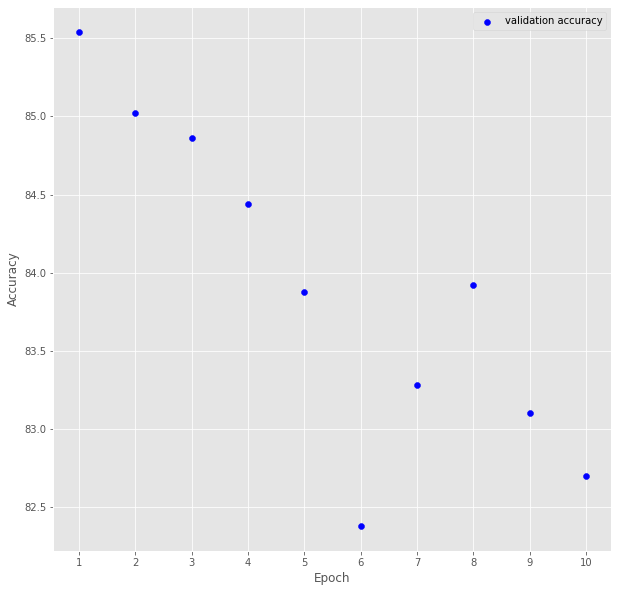

In [34]:
plt.scatter(range(1,num_epochs+1),val_accs, color = 'b', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,num_epochs+1)))
plt.legend()